<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Введение" data-toc-modified-id="Введение-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка</a></span></li><li><span><a href="#Анализ-и-подготовка-данных" data-toc-modified-id="Анализ-и-подготовка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ и подготовка данных</a></span></li><li><span><a href="#Подготовка-данных-для-обучения." data-toc-modified-id="Подготовка-данных-для-обучения.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных для обучения.</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

#  Прогнозирование заказов такси

## Введение

В нашем распоряжении исторические данные заказов такси в аэропортах за пять месяцев 2018 года с шагом в 10 минут. Для того, чтобы заблаговременно отправлять необходимое количество водителей в аэропорт и обеспечить качественный сервис прилетающим клиентам, необходимо разработать модель машинного обучения, которая на основании имеющихся данных сможет предсказывать количество заказов в следующий час. 

В качетсве метрики оценки качества модели выберем RMSE. Пороговое значения, со значениями ниже которого, модель считается интересной для бизнеса составляет 48 заказов в час. 

План разработки модели: 

1. Проверим корректность данных, при необходимости проведем предобработку
2. Выполним ресемплирование датасета таким образом, чтобы шаг стал равным одному часу. 
3. Проанализируем тренды и сезонность в имеющихся данных. 
4. Подготовим данные для обучения, создав несколько доп. признаков, разделив выборку на тренировочную и валидационную 
5. Обучим несколько моделей. 
6. Выберем лучшую и проверим ее на валидационных данных. 

## Предобработка

In [281]:
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import numpy as np
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

In [282]:
df = pd.read_csv('/datasets/taxi.csv')

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Видим две колонки, в каждой из которых по 26496 записей. 

Необходимо изменить тип данных в колонке 'datetime'

In [284]:
df['datetime']=df['datetime'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Проверим, есть ли пустые значения в теблице. 

In [285]:
df['datetime'].isna().sum()

0

Пустых значений - нет. 

Изучим значения в колонке `num_orders`

<AxesSubplot:>

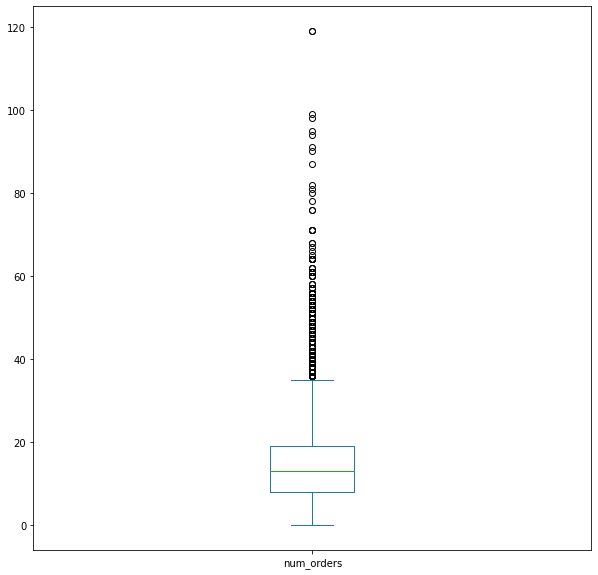

In [286]:
df['num_orders'].plot(kind = 'box',
                     figsize = (10,10))

Видно, что в данных есть выбросы. Но, так как данные собраны автоматически, это не является ошибкой, а скорее всего говорит о пиковых часах. Оставим значения, как есть. 

Изучим данные в колонке `datetime`

In [287]:
print ('Максимальная дата:', df['datetime'].max().year, df['datetime'].max().month)
print ('Минимальная дата:', df['datetime'].min().year, df['datetime'].min().month)
print (df['datetime'])

Максимальная дата: 2018 8
Минимальная дата: 2018 3
0       2018-03-01 00:00:00
1       2018-03-01 00:10:00
2       2018-03-01 00:20:00
3       2018-03-01 00:30:00
4       2018-03-01 00:40:00
                ...        
26491   2018-08-31 23:10:00
26492   2018-08-31 23:20:00
26493   2018-08-31 23:30:00
26494   2018-08-31 23:40:00
26495   2018-08-31 23:50:00
Name: datetime, Length: 26496, dtype: datetime64[ns]


В колонке `datetime` представлены данные за 5 месяцев с марта 2018 года до августа включительно с шагом в 10 минут. 

## Анализ и подготовка данных

Перенесем дату в индекс таблицы. 

In [288]:
df = df.set_index('datetime')

Выполним ресемплинг данных таким образом, чтобы шаг стал равен одному дню. 

In [289]:
df = df.resample('1H').sum()

In [290]:
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Временной ряд ресемплирован. Визуализируем его. 

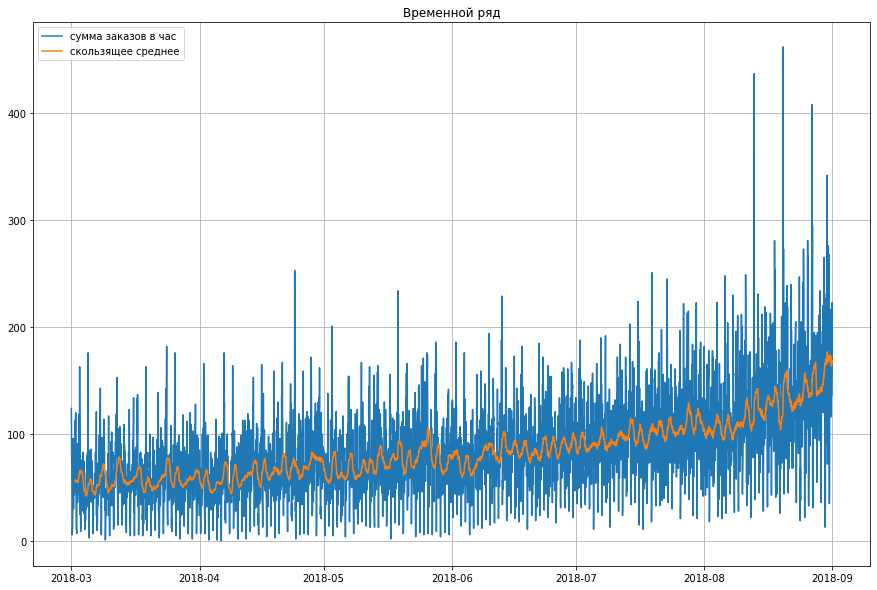

In [291]:
plt.figure(figsize=(15,10))
plt.plot(df,label =  'сумма заказов в час')
plt.grid()
plt.title('Временной ряд')
plt.plot(df.rolling(24).mean(),label = 'скользящее среднее')
plt.legend()
plt.show()

Видно, что ряд не стационарен. 
Проанализируем тренды, сезонность и шум в данных. 

In [292]:
decomposed = seasonal_decompose(df)

<Figure size 432x288 with 0 Axes>

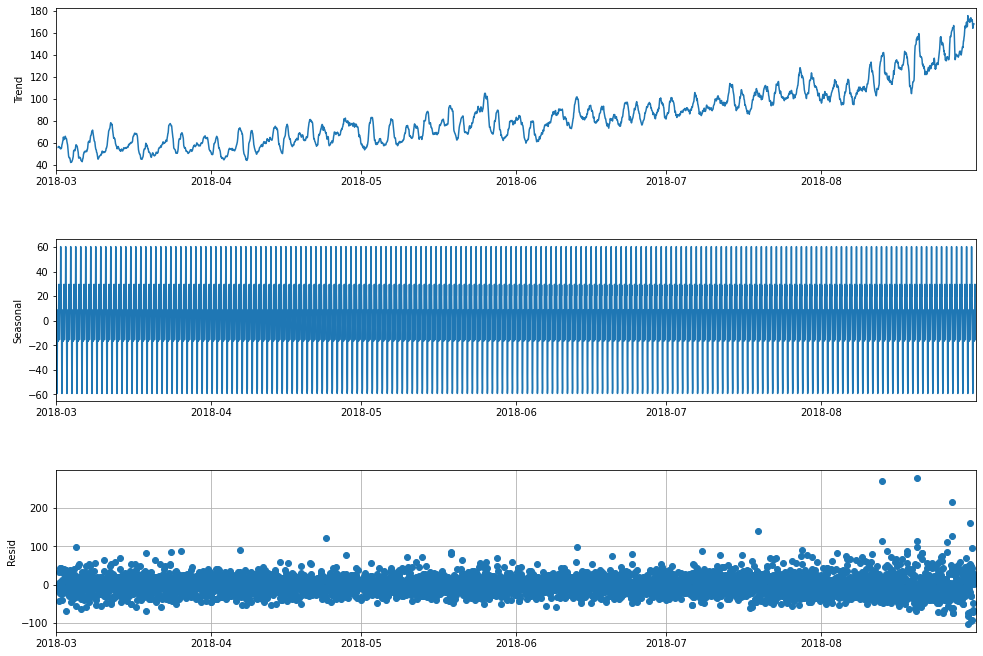

In [293]:
plt.figure()
figure = decomposed.plot(observed =False)
figure.set_size_inches((15,10))
plt.grid()
plt.show()

Можно отметить возрастающий тренд на услуги такси. Рассмотрим меньший промежуток времени, август 2018 года. 

<Figure size 432x288 with 0 Axes>

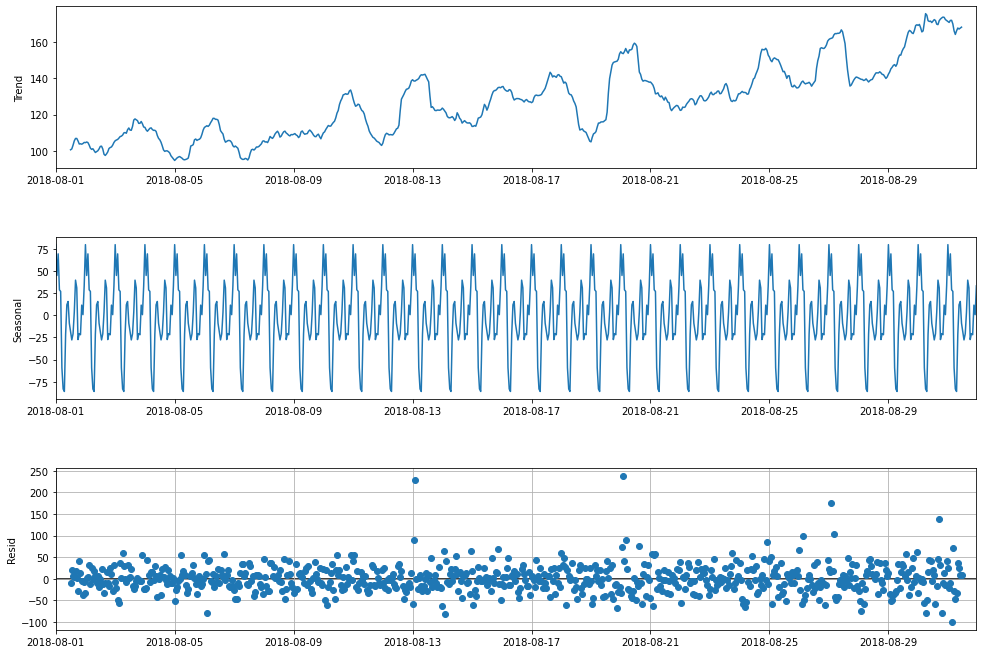

In [294]:
df_last_month = df['2018-08-01':'2018-08-31']
decomposed = seasonal_decompose(df_last_month)
plt.figure()
figure = decomposed.plot(observed =False)
figure.set_size_inches((15,10))
plt.grid()
plt.show()

Из данных видно, что спрос на услуги такси повышается в выходные дни. Это, скорее всего, связано с тем, что значительная часть людей возвращается из отпуска в эти дни. При этом, к концу месяца спрос возрастает и сохраняется даже в выходные. Это можно связать с наступлением нового учебного года и необходимостью возвращения перед его началом домой. 

<Figure size 432x288 with 0 Axes>

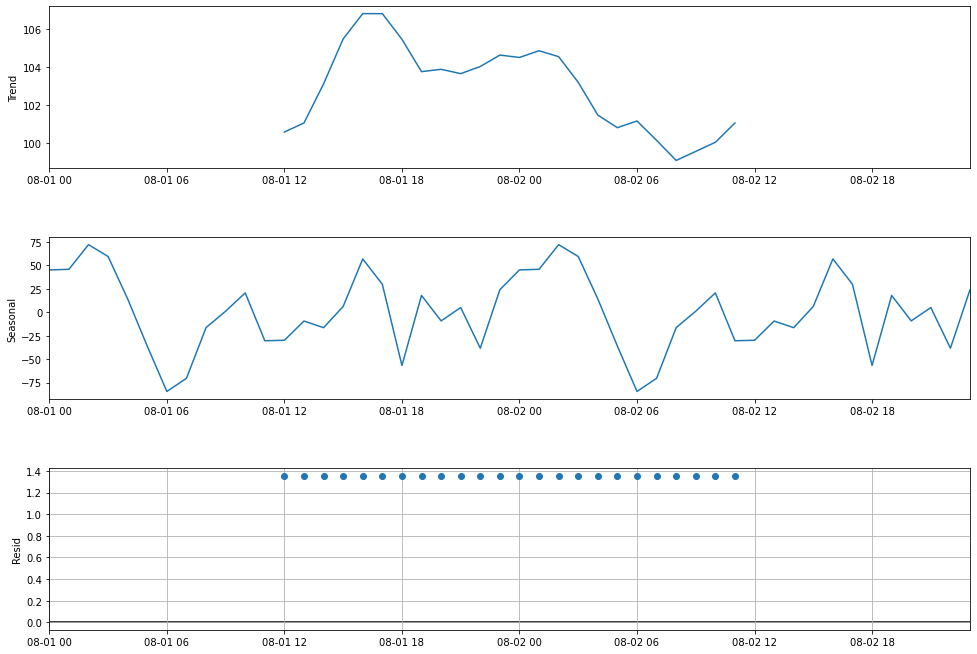

In [295]:
df_one_day = df['2018-08-01 00:00:00':'2018-08-02 23:00:00']
decomposed = seasonal_decompose(df_one_day)
plt.figure()
figure = decomposed.plot(observed =False)
figure.set_size_inches((15,10))
plt.grid()
plt.show()

## Подготовка данных для обучения. 

Создадим признаки. 

Скользящее среднее.
Значение предыдущего, дух и трех часов.   
Номер дня недели.
День месяца. 

Выносить номер месяца, года не имеет смысла, так как у нас данные только за пять месяцев 2018 года. 

In [296]:
df['rolling_mean'] = df['num_orders'].rolling(5).mean() #Скользящее среднее за 6 часов. 
df['lag_1'] = df['num_orders'].shift(1)
df['lag_2'] = df['num_orders'].shift(2)
df['lag_3'] = df['num_orders'].shift(3)
df['week_day_number'] = df.index.dayofweek
df['hour'] = df.index.hour

In [297]:
df = df.dropna()
df

,num_orders,rolling_mean,lag_1,lag_2,lag_3,week_day_number,hour
datetime,,,,,,,
2018-03-01 04:00:00,43,77.8,66.0,71.0,85.0,3,4
2018-03-01 05:00:00,6,54.2,43.0,66.0,71.0,3,5
2018-03-01 06:00:00,12,39.6,6.0,43.0,66.0,3,6
2018-03-01 07:00:00,15,28.4,12.0,6.0,43.0,3,7
2018-03-01 08:00:00,34,22.0,15.0,12.0,6.0,3,8
...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,174.6,207.0,217.0,197.0,4,19
2018-08-31 20:00:00,154,182.2,136.0,207.0,217.0,4,20
2018-08-31 21:00:00,159,174.6,154.0,136.0,207.0,4,21


Разделим выборки на обуающую и тестовую. В пропорциях 5 к 1.

Валидировать обученные модели будем с помощью кросс-валидации. 

Проверку на вменяемость выполним с помощью прогноза по разности временного ряда. 

In [298]:
features = df.drop(columns = 'num_orders')
target = df['num_orders']

features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                                                                              random_state=12345,
                                                                             test_size=0.1,
                                                                             shuffle=False)

print (features_train.shape)
print (features_valid.shape)
print (target_train.shape)
print (target_valid.shape)

(3970, 6)
(442, 6)
(3970,)
(442,)


In [299]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

Выборки сформированы, данные готовы к обучению. 

## Обучение

### Линейная регрессия

In [300]:
model = LinearRegression()
scores = []
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(features_train):
    x_train = features_train[train_index]
    x_test = features_train[test_index]
    y_train = target_train[train_index]
    y_test = target_train[test_index]
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    score = mean_squared_error(y_test, predictions, squared=False)
    scores.append(score)
print ('Метрика RMSE для линейной регрессии составляет:',np.median(np.array(scores)))

Метрика RMSE для линейной регрессии составляет: 21.68914192583055


### Catboost

In [301]:
best_result = 35 #Нижняя планка, от которой оттолкнемся. 
best_model = 0
for i in range (5, 15):
    for d in range (7,12):
        model = CatBoostRegressor(iterations=i,
                                   depth=d,
                                   learning_rate=0.7,
                                   loss_function='RMSE',
                                   verbose=True)
        scores = []
        tscv = TimeSeriesSplit()
        for train_index, test_index in tscv.split(features_train):
            x_train = features_train[train_index]
            x_test = features_train[test_index]
            y_train = target_train[train_index]
            y_test = target_train[test_index]
            model.fit(x_train, y_train)
            predictions = model.predict(x_test)
            score = mean_squared_error(y_test, predictions, squared=False)
            scores.append(score)
        median_score = np.median(np.array(scores))
        if median_score<best_result:
            best_result = median_score
            print (median_score)
            best_model = model

0:	learn: 20.4499678	total: 1.87ms	remaining: 7.47ms
1:	learn: 17.2021935	total: 3.01ms	remaining: 4.52ms
2:	learn: 15.9994742	total: 3.88ms	remaining: 2.59ms
3:	learn: 14.8991071	total: 4.72ms	remaining: 1.18ms
4:	learn: 14.2763099	total: 5.75ms	remaining: 0us
0:	learn: 20.9196113	total: 949us	remaining: 3.8ms
1:	learn: 19.2574966	total: 1.95ms	remaining: 2.92ms
2:	learn: 17.7076718	total: 2.9ms	remaining: 1.93ms
3:	learn: 16.5329058	total: 3.85ms	remaining: 962us
4:	learn: 15.5102668	total: 5.14ms	remaining: 0us
0:	learn: 22.8046521	total: 1.92ms	remaining: 7.67ms
1:	learn: 20.4756877	total: 2.99ms	remaining: 4.49ms
2:	learn: 19.0363538	total: 4.1ms	remaining: 2.73ms
3:	learn: 17.7908185	total: 5.27ms	remaining: 1.32ms
4:	learn: 16.6577927	total: 6.3ms	remaining: 0us
0:	learn: 24.2157260	total: 1.29ms	remaining: 5.16ms
1:	learn: 22.2060854	total: 3.03ms	remaining: 4.55ms
2:	learn: 20.0051504	total: 4.19ms	remaining: 2.8ms
3:	learn: 19.0660395	total: 5.41ms	remaining: 1.35ms
4:	learn:

In [302]:
best_model.get_params()

{'iterations': 14,
 'learning_rate': 0.7,
 'depth': 8,
 'loss_function': 'RMSE',
 'verbose': True}

In [303]:
scores = []
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(features_train):
    x_train = features_train[train_index]
    x_test = features_train[test_index]
    y_train = target_train[train_index]
    y_test = target_train[test_index]
    best_model.fit(x_train, y_train)
    predictions = best_model.predict(x_test)
    score = mean_squared_error(y_test, predictions, squared=False)
    scores.append(score)
median_score = np.median(np.array(scores))

0:	learn: 20.2719891	total: 1.15ms	remaining: 15ms
1:	learn: 16.6867267	total: 2.29ms	remaining: 13.7ms
2:	learn: 15.1511026	total: 3.35ms	remaining: 12.3ms
3:	learn: 14.1960248	total: 4.42ms	remaining: 11.1ms
4:	learn: 13.7047571	total: 5.66ms	remaining: 10.2ms
5:	learn: 13.1147601	total: 7.43ms	remaining: 9.9ms
6:	learn: 12.3052851	total: 8.6ms	remaining: 8.6ms
7:	learn: 11.6533790	total: 9.63ms	remaining: 7.22ms
8:	learn: 11.3044860	total: 10.6ms	remaining: 5.91ms
9:	learn: 10.6523449	total: 11.7ms	remaining: 4.69ms
10:	learn: 10.2383103	total: 12.8ms	remaining: 3.5ms
11:	learn: 9.6916996	total: 14.4ms	remaining: 2.4ms
12:	learn: 9.3596300	total: 15.8ms	remaining: 1.21ms
13:	learn: 9.0965185	total: 17.2ms	remaining: 0us
0:	learn: 20.7592077	total: 1.23ms	remaining: 16ms
1:	learn: 18.7237343	total: 2.48ms	remaining: 14.9ms
2:	learn: 16.7661625	total: 4.22ms	remaining: 15.5ms
3:	learn: 16.0204662	total: 5.68ms	remaining: 14.2ms
4:	learn: 15.2666451	total: 7.15ms	remaining: 12.9ms
5:	l

In [304]:
median_score

20.57226309396441

На основании полученных значений, выберем линейную регрессию в качетсве целевой модели и проверим на валидационных данных. 

## Тестирование

In [305]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
mean_squared_error(target_valid, predictions, squared=False)

36.88736037104836

Проверим модель на вменяемость сравнив с прогнозами, основанными на предыдущих значениях таблицы. 

In [306]:
predictions = target_valid.shift(1, fill_value=target_train.iloc[-1])
mean_squared_error(target_valid, predictions, squared=False)

58.856486242815066

Модель вменяема. Полученное значение < 48. 

## Выводы

На вход были получены исторические данные по заказам такси в аэропорт за пять месяцев 2018 года с шагом в 10 минут. 

Данные были предобработаны, ресемплированы. 

Можно отметить общий возрастающий тренд на количетсво заказов такси в аэропорт. Сезонных особенностей отмечено не было, так как данные приведены менее, чем за полгода. 

На основе тренировочных данных были обучены две модели машинного обучения, LinearRegression и CatBoost. 
В качестве метрики качества обучения выбрана метрика RMSE. Лучше обучилась модель LineearRegression. 
На валидационных данных ошибка составила 36,84. 